<a href="https://colab.research.google.com/github/ryzhokhina/Tensorflow-Dev-Exam-Preparation/blob/main/NLP/nlp_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-28 01:17:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-28 01:17:30 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

# Load data

In [3]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-07-28 01:17:34--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.96.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  1.30MB/s    in 0.4s    

2023-07-28 01:17:35 (1.30 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#Load a pretrained encoder - USA - universal sentense encoder

In [6]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [7]:
test_sencence = train_df["text"][0]
test_sencence


'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [8]:
embedding_text = embed([test_sencence])
embedding_text.shape


TensorShape([1, 512])

# Split data to train and validate sets


In [9]:
from sklearn.model_selection import train_test_split


# Split data to train and validate sets
x_train, x_valid, y_train, y_valid = train_test_split(train_df["text"],
                                                      train_df["target"],
                                                      test_size=0.2,
                                                      random_state=42)


In [10]:
x_train.head()

4996    Courageous and honest analysis of need to use ...
3263    @ZachZaidman @670TheScore wld b a shame if tha...
4907    Tell @BarackObama to rescind medals of 'honor'...
2855    Worried about how the CA drought might affect ...
4716    @YoungHeroesID Lava Blast &amp; Power Red #Pan...
Name: text, dtype: object

In [11]:
x_valid.head()

2644    So you have a new weapon that can cause un-ima...
2227    The f$&amp;@ing things I do for #GISHWHES Just...
5448    DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...
132     Aftershock back to school kick off was great. ...
6845    in response to trauma Children of Addicts deve...
Name: text, dtype: object

# Create a model to classification using USA embedding

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout
from tensorflow.keras.models import Model


In [13]:
# create encodel layer
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                         input_shape=[],
                         dtype=tf.string,
                         trainable=False,
                         name="encoder")


In [14]:
def create_model():
    inputs = tf.keras.Input(shape=tf.shape(''), dtype=tf.string)
    x = encoder(inputs)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=x)

    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])

    return model

In [15]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 encoder (KerasLayer)        (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33    

In [16]:
MC = tf.keras.callbacks.ModelCheckpoint("model.h5", monitor="val_accuracy", save_best_only=True)
ES = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
LRC = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=5, factor=0.2, min_lr=0.00001)

history = model.fit(
    x_train,
    y_train, epochs=100,
    validation_data=(x_valid, y_valid),
    callbacks = [MC, ES, LRC])


Epoch 1/100
191/191 [==============================] - 15s 57ms/step - loss: 0.5069 - accuracy: 0.7675 - val_loss: 0.4472 - val_accuracy: 0.7932 - lr: 0.0010
Epoch 2/100
191/191 [==============================] - 9s 50ms/step - loss: 0.4159 - accuracy: 0.8202 - val_loss: 0.4125 - val_accuracy: 0.8142 - lr: 0.0010
Epoch 3/100
191/191 [==============================] - 9s 49ms/step - loss: 0.3947 - accuracy: 0.8310 - val_loss: 0.4080 - val_accuracy: 0.8221 - lr: 0.0010
Epoch 4/100
191/191 [==============================] - 10s 54ms/step - loss: 0.3704 - accuracy: 0.8458 - val_loss: 0.4118 - val_accuracy: 0.8227 - lr: 0.0010
Epoch 5/100
191/191 [==============================] - 13s 68ms/step - loss: 0.3507 - accuracy: 0.8544 - val_loss: 0.4112 - val_accuracy: 0.8280 - lr: 0.0010
Epoch 6/100
191/191 [==============================] - 3s 14ms/step - loss: 0.3271 - accuracy: 0.8663 - val_loss: 0.4155 - val_accuracy: 0.8207 - lr: 0.0010
Epoch 7/100
191/191 [==============================] - 

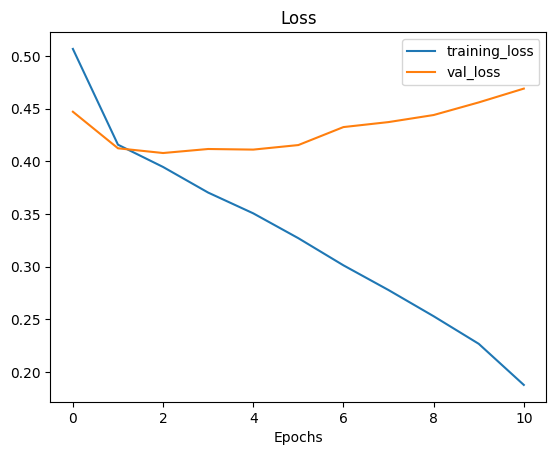

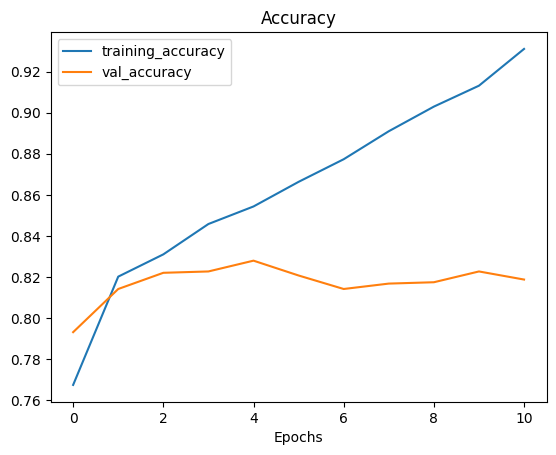

In [17]:
plot_loss_curves(history)


In [18]:
model.evaluate(x_valid, y_valid)


48/48 [==============================] - 1s 10ms/step - loss: 0.4112 - accuracy: 0.8280


[0.41122186183929443, 0.8279711008071899]

In [19]:
model.save('/content/drive/MyDrive/ai_model/best_model.h5')

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 encoder (KerasLayer)        (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33    

## Classification model using TF- BERT

In [21]:
import tensorflow as tf
import tensorflow_hub as hub

In [22]:
tf.__version__


'2.12.0'

In [25]:
pip install tensorflow-text==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 25.5 MB/s eta 0:00:00


In [26]:
import tensorflow_text

In [27]:
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/2" # @param {type: "string"} ["https://tfhub.dev/google/experts/bert/wiki_books/2", "https://tfhub.dev/google/experts/bert/wiki_books/mnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qqp/2", "https://tfhub.dev/google/experts/bert/wiki_books/squad2/2", "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2",  "https://tfhub.dev/google/experts/bert/pubmed/2", "https://tfhub.dev/google/experts/bert/pubmed/squad2/2"]
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [ ]:
BERT_MODEL

In [ ]:
preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)
inputs = preprocess(["text sentences"])
outputs = bert(inputs)

In [ ]:
outputs['pooled_output'].shape, outputs['sequence_output'].shape, len(outputs['encoder_outputs']), outputs['encoder_outputs'][0].shape


### create a model

In [36]:
def create_bert_model(tfhub_handle_preprocess, tfhub_handle_encoder) :

    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    bert_model = hub.KerasLayer(tfhub_handle_encoder)

    inputs = tf.keras.Input(shape=tf.shape(''), dtype=tf.string)
    x = bert_preprocess_model(inputs)
    x = bert_model(x)
    x = Dense(128, activation="relu")(x['pooled_output']) # embeddings for a whole sentence
    x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=x)

    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])

    return model


In [37]:
bert_model = create_bert_model(PREPROCESS_MODEL, BERT_MODEL)
bert_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_word_ids':   0           ['input_4[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [38]:
MC_BERT = tf.keras.callbacks.ModelCheckpoint("model_bert.h5", monitor="val_accuracy", save_best_only=True)
ES_BERT = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
LRC_BERT = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=3, factor=0.2, min_lr=0.00001)

history_bert= bert_model.fit(
      x_train,
      y_train, epochs=100,
      validation_data=(x_valid, y_valid),
      callbacks=[MC_BERT, ES_BERT, LRC_BERT])


Epoch 1/100
191/191 [==============================] - 99s 465ms/step - loss: 0.6678 - accuracy: 0.5905 - val_loss: 0.6339 - val_accuracy: 0.6553 - lr: 0.0010
Epoch 2/100
191/191 [==============================] - 84s 439ms/step - loss: 0.6337 - accuracy: 0.6470 - val_loss: 0.5716 - val_accuracy: 0.7242 - lr: 0.0010
Epoch 3/100
191/191 [==============================] - 84s 441ms/step - loss: 0.5885 - accuracy: 0.7043 - val_loss: 0.5853 - val_accuracy: 0.6743 - lr: 0.0010
Epoch 4/100
191/191 [==============================] - 91s 476ms/step - loss: 0.5675 - accuracy: 0.7207 - val_loss: 0.5349 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 5/100
191/191 [==============================] - 96s 504ms/step - loss: 0.5384 - accuracy: 0.7381 - val_loss: 0.4967 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 6/100
191/191 [==============================] - 85s 443ms/step - loss: 0.5345 - accuracy: 0.7448 - val_loss: 0.5084 - val_accuracy: 0.7663 - lr: 0.0010
Epoch 7/100
191/191 [=========================

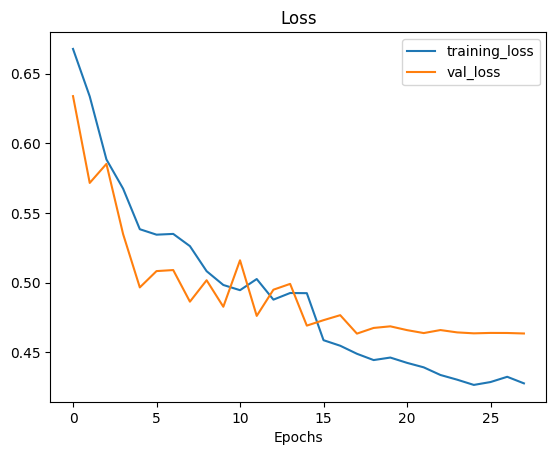

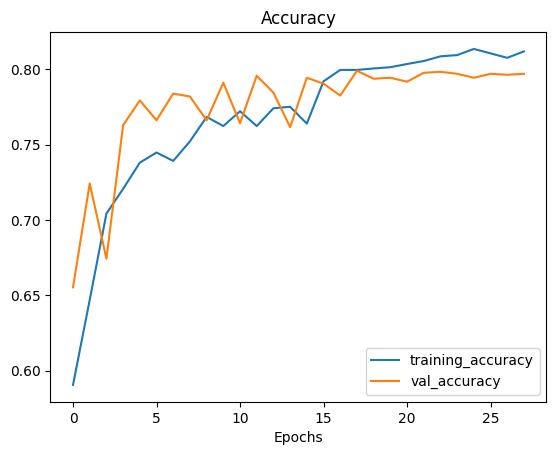

In [39]:
plot_loss_curves(history_bert)

In [40]:
bert_model.evaluate(x_valid, y_valid)

48/48 [==============================] - 16s 336ms/step - loss: 0.4635 - accuracy: 0.7991


[0.4635004997253418, 0.7990807890892029]

In [41]:
bert_model.save('/content/drive/MyDrive/ai_model/bert_model.h5')

In [43]:
bert_model.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))

Epoch 1/5
191/191 [==============================] - 85s 446ms/step - loss: 0.4406 - accuracy: 0.8072 - val_loss: 0.4641 - val_accuracy: 0.7965
Epoch 2/5
191/191 [==============================] - 85s 443ms/step - loss: 0.4375 - accuracy: 0.8026 - val_loss: 0.4636 - val_accuracy: 0.7971
Epoch 3/5
191/191 [==============================] - 84s 442ms/step - loss: 0.4468 - accuracy: 0.8002 - val_loss: 0.4641 - val_accuracy: 0.7971
Epoch 4/5
191/191 [==============================] - 84s 441ms/step - loss: 0.4380 - accuracy: 0.8067 - val_loss: 0.4643 - val_accuracy: 0.7984
Epoch 5/5
191/191 [==============================] - 84s 442ms/step - loss: 0.4361 - accuracy: 0.8092 - val_loss: 0.4643 - val_accuracy: 0.7978
